We first import stim, pymatching, and other dependencies.

In [1]:
import stim # Quantum circuits
import pymatching # Decoding
import sinter # MC sampling
from typing import List # Organizing input to sinter
import matplotlib.pyplot as plt # Plotting

Add some functions that can allow us to generate circuits, perhaps complex ones, using basic function arguments. In the end, what we would want to do is to write a master function to compose sinter tasks such that it receives these circuit generator functions and a dictionary for their arguments.

In [7]:
# A bunch of example functions to generate circuits
# Add more as needed
def get_builtin_circuit(builtin_name, distance, rounds, **noise_args):
  """
  Wrapper around the stim.Circuit.generated function to generate a circuit.
  - Arguments:
    builtin_name: Name of the builtin circuit to generate.
    distance: Distance of the code.
    rounds: Number of rounds of the circuit.
    noise_args: Noise parameters to use.
  - Return type:
    stim.Circuit
  """
  return stim.Circuit.generated(
    code_task = builtin_name, distance = distance, rounds = rounds,
    **noise_args
  )

Here are master functions to use sinter to benchmark built-in or other custom decoders with various circuits to make sampling tasks, collect their results, and make various plots.

In [51]:
# sinter_args could be the json_metadata or anything else
def compose_sinter_task(fcn_circuit_generator, args_circuit_generator, **sinter_args):
  """
  Compose a sinter task given a circuit generator function, its arguments, and any extra arguments to sinter.Task.
  - Arguments:
    fcn_circuit_generator: Function that generates the circuit. Could be any function that returns a stim.Circuit.
    args_circuit_generator: Arguments to the circuit generator.
    sinter_args: Arguments to the sinter task. An example could be json_metadata. Check sinter.Task help for more details.
  - Return type:
    sinter.Task
  - Example call:
    compose_sinter_task(
      get_builtin_circuit,
      {"builtin_name": "repetition_code:memory", "distance": 5, "rounds": 3, "before_round_data_depolarization": 0.1},
      json_metadata = {"distance": 5, "error_rate": 0.1}
    )
  """
  return sinter.Task(
    circuit = fcn_circuit_generator(**args_circuit_generator),
    **sinter_args
  )

def run_sinter_collect(num_workers, tasks, num_samples, decoders, **sinter_collect_args):
  """
  Run a sinter collect task given a number of workers, tasks, decoders, number of samples, and any extra arguments to sinter.collect.
  - Arguments:
    num_workers: Number of worker nodes.
    tasks: List of sinter.Task objects.
    decoders: List of decoders. Either use this argument, or set this to None with custom_decoders argument specified.
    num_samples: Number of samples to use.
    sinter_collect_args: Extra arguments to sinter.collect.
  - Return type:
    sinter.CollectResult
  - Example call:
    run_sinter_collect(
      num_workers = 4,
      tasks = [task1, task2],
      decoders = ['pymatching'], # or set the custom_decoders argument
      num_samples = 1000000
    )
  """
  return sinter.collect(
    num_workers = num_workers,
    tasks = tasks,
    decoders = decoders,
    max_shots = num_samples,
    **sinter_collect_args
  )

def get_variable_from_sinter_collect_result(result, varname, varlabels=None):
  """
  Get a label from the result of the sinter.collect call.
  - Arguments:
    result: A sinter.TaskStats object.
    varname: Name of the label to get from the json_metadata, or some other object in the result data.
    varlabels: Label dictionary for the variable.
      If not None (default), the function attempts to map replace the entries with strings specified in this dictionary.
  - Return type:
    List
  - Example call:
    get_variable_from_sinter_collect_result(result, "distance")
  """
  res = None
  if hasattr(result, varname):
    res = getattr(result, varname)
  elif varname in result.json_metadata:
    res = result.json_metadata[varname]
  if res is None:
    raise RuntimeError(f"Label {varname} not found in the result.")
  if varlabels is not None:
    if res in varlabels:
      res = varlabels[res]
  return res

def plot_sinter_error_rate(
    ax, results,
    x_title, x_label=None, y_label=None,
    plot_label=None,
    group_title=None,
    group_labels=None,
    x_range=None, y_range=None,
    use_log_scale = True,
    **sinter_plotter_args
    ):
  """
  Plot the results from sinter.
  - Arguments:
    ax: Axes object to plot on.
    results: sinter.CollectResult object.
    x_title: Name of the json_metadata variable to use in the x-axis, or could be another entry in the results argument.
    x_label: Label for the x-axis. The default is to use x_title if set to None.
    y_label: Label for the y-axis. The default is to use y_title if set to None.
    plot_label: Title for the plot at the top. Defaulted to None for no plot title.
    group_title: Label for grouping the results. Defaulted to None for no grouping.
    group_labels: Labels dictionary of the grouping in the legend. Defaulted to None for no labeling.
      This argument is ignored if group_title is None.
    
    Note:
      The group_title and group_labels arguments are supposed to be passed as
        group_func = lambda st, tt=group_title, lbl=group_labels: get_variable_from_sinter_collect_result(st, tt, lbl)
      into the group_func argument of sinter.plot_error_rate.

    x_range: Range for the x-axis. Defaulted to None for no custom range.
    y_range: Range for the y-axis. Defaulted to None for no custom range.
    use_log_scale: Whether to use log scale for the axes. Defaulted to True.
    sinter_plotter_args: Extra arguments to the sinter plotter.
  - Return type:
    None
  - Example call:
    plot_sinter_result(
      ax = ax,
      results = result,
      x_title = "noise",
      x_label = "Physical noise",
      y_label = "Logical errors per sample",
      plot_label = "Physical and logical error rates",
      group_title = "decoder"
      group_labels = {'pymatching': "pyMatching"}
    )
  """
  fcn_x = lambda st, tt=x_title: get_variable_from_sinter_collect_result(st, tt)
  fcn_group = lambda st, tt=group_title, lbl=group_labels: get_variable_from_sinter_collect_result(st, tt, lbl) if group_title is not None else None
  sinter.plot_error_rate(
    ax = ax,
    stats = results,
    x_func = fcn_x,
    group_func = fcn_group
  )
  if x_range is not None:
    ax.set_xlim(x_range)
  if y_range is not None:
    ax.set_ylim(y_range)
  if plot_label is not None:
    ax.set_title(plot_label)
  if x_label is None:
    x_label = x_title
  ax.set_xlabel(x_label)
  if y_label is not None:
    ax.set_ylabel(y_label)
  if use_log_scale:
    ax.loglog()
  ax.grid(which='major')
  #ax.grid(which='minor')
  ax.legend()


Let's run the repetition code example from stim [getting_started](https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb) manual using the above master functions.

In [55]:
tasks = [
  compose_sinter_task(
    fcn_circuit_generator = get_builtin_circuit,
    args_circuit_generator = {"builtin_name": "repetition_code:memory", "distance": d, "rounds": 3*d, "before_round_data_depolarization": noise},
    json_metadata = {'distance': d, 'noise': noise, 'rounds': 3*d}
  )
  for d in [3, 5, 7, 9]
  for noise in [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
]

results: List[sinter.TaskStats] = run_sinter_collect(
  num_workers = 4,
  tasks = tasks,
  decoders = ['pymatching'],
  num_samples = 1000000,
  #max_errors=500,
)

Let's make figures for error rates per shot...

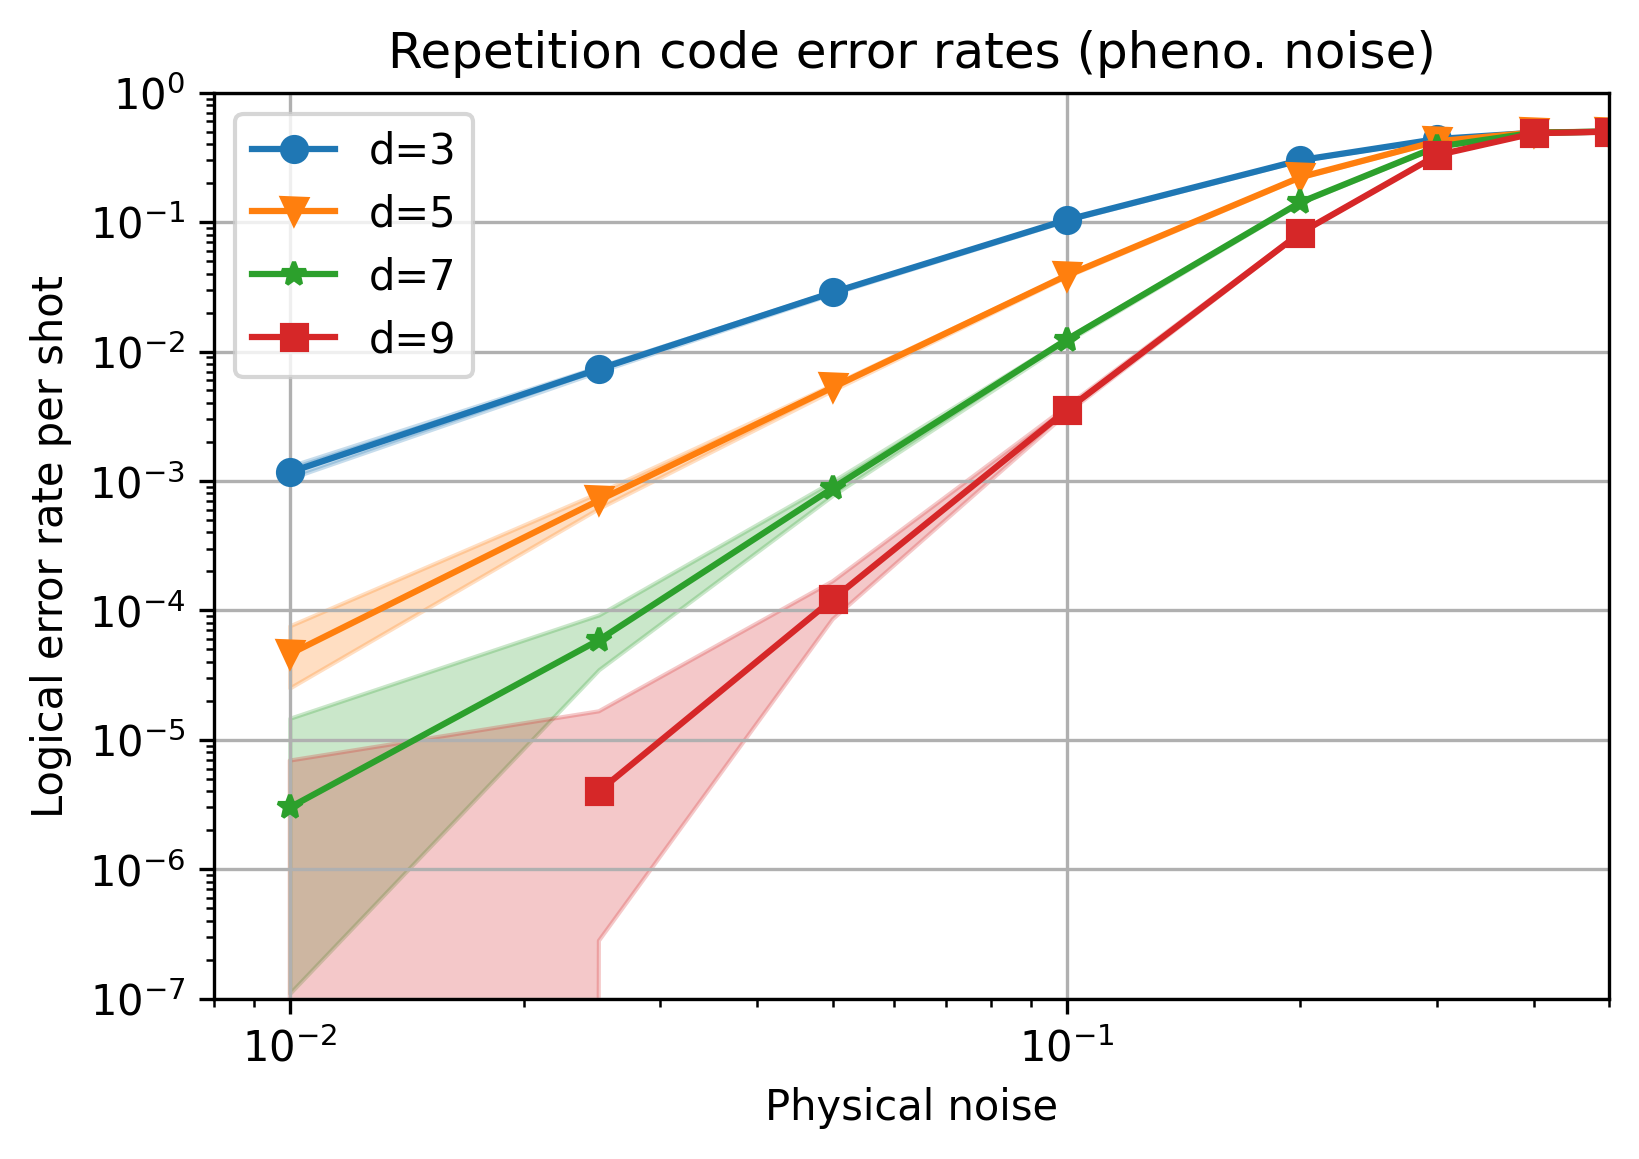

In [56]:
fig, ax = plt.subplots(1, 1)
plot_sinter_error_rate(
  ax, results, "noise", "Physical noise", "Logical error rate per shot",
  plot_label="Repetition code error rates (pheno. noise)",
  group_title="distance", group_labels={3: "d=3", 5: "d=5", 7: "d=7", 9: "d=9"},
  x_range=(0.008, 0.5), y_range=(1e-7, 1.)  
)
fig.set_dpi(300)

...and per round.

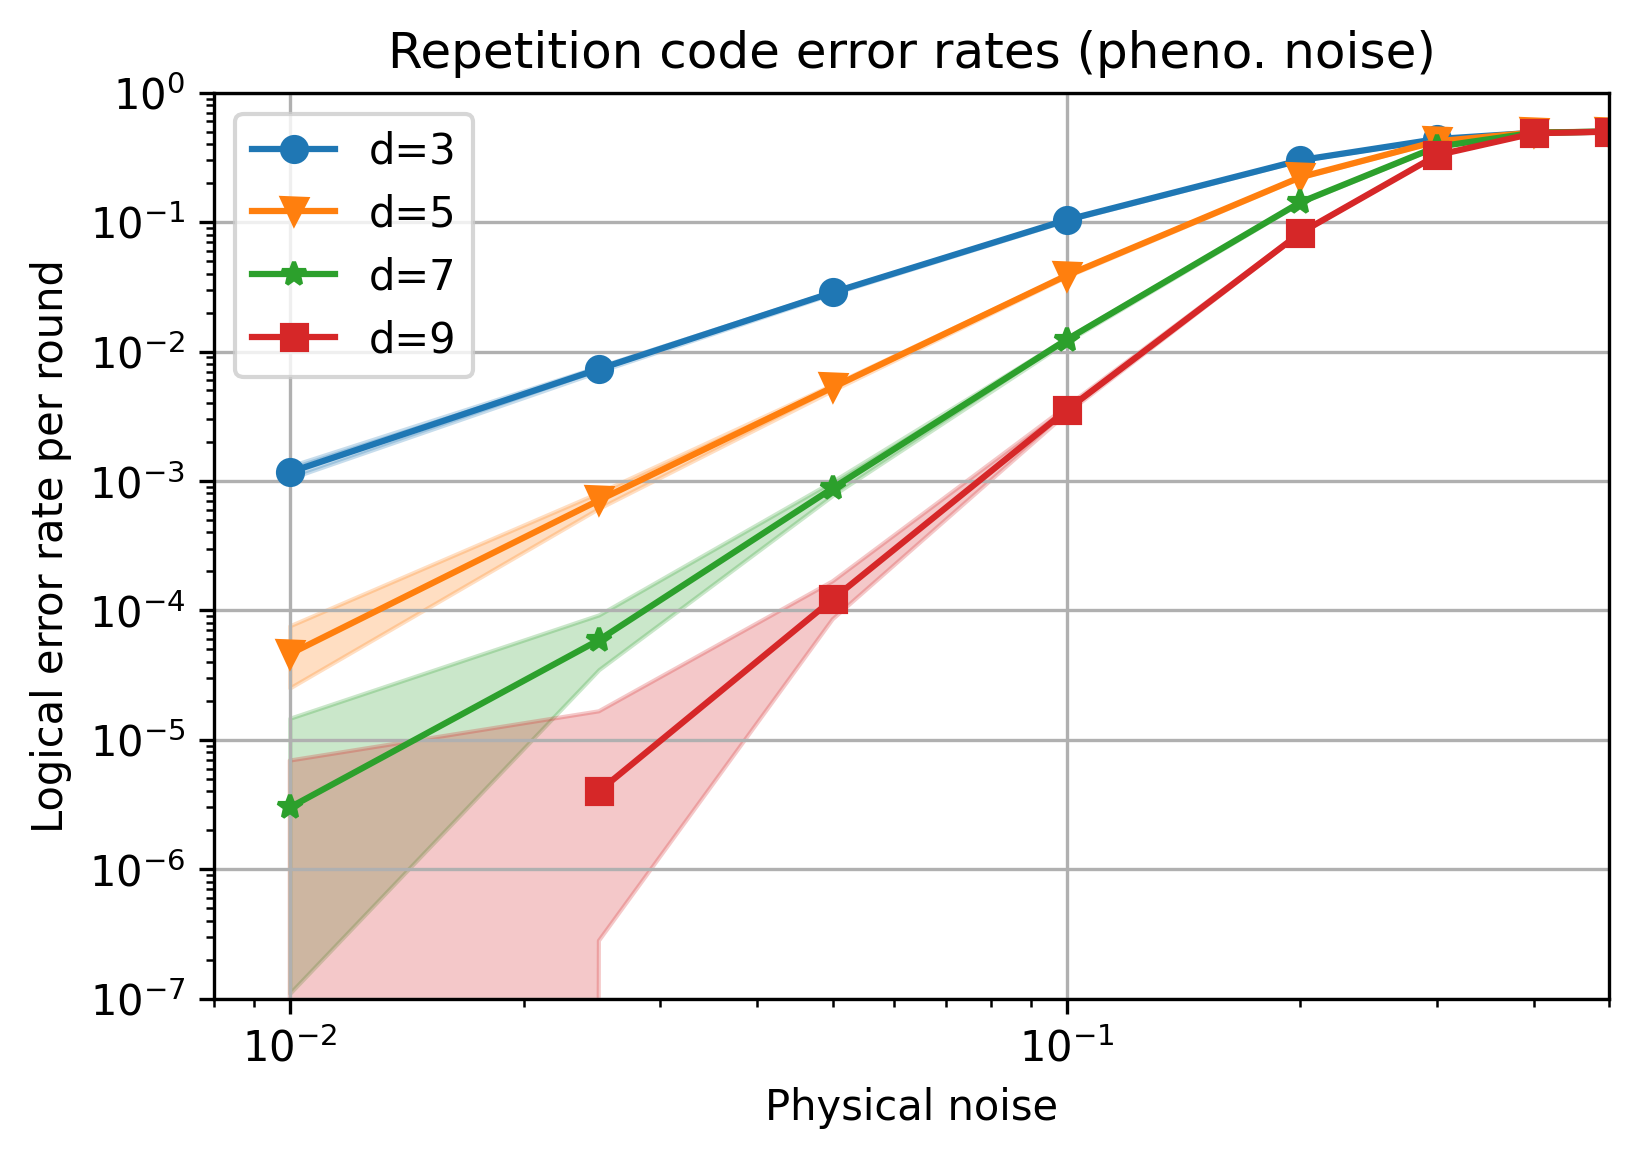

In [57]:
fig, ax = plt.subplots(1, 1)
plot_sinter_error_rate(
  ax, results, "noise", "Physical noise", "Logical error rate per round",
  plot_label="Repetition code error rates (pheno. noise)",
  group_title="distance", group_labels={3: "d=3", 5: "d=5", 7: "d=7", 9: "d=9"},
  x_range=(0.008, 0.5), y_range=(1e-7, 1.),
  failure_units_per_shot_func = lambda st, tt="rounds": get_variable_from_sinter_collect_result(st, tt)
)
fig.set_dpi(300)

Let's try surface codes...

In [58]:
tasks = [
  compose_sinter_task(
    fcn_circuit_generator = get_builtin_circuit,
    args_circuit_generator = {
      "builtin_name": "surface_code:rotated_memory_z", "distance": d, "rounds": 3*d,
      "after_reset_flip_probability": noise,
      "after_clifford_depolarization": noise,
      "before_round_data_depolarization": noise,
      "before_measure_flip_probability": noise,
      },
    json_metadata = {'distance': d, 'noise': noise, 'rounds': 3*d}
  )
  for d in [3, 4, 5]
  for noise in [0.001, 0.0015, 0.005, 0.075]
]

results: List[sinter.TaskStats] = run_sinter_collect(
  num_workers = 4,
  tasks = tasks,
  decoders = ['pymatching'],
  num_samples = 1000000,
  #max_errors=500,
)

Let's make the figures...

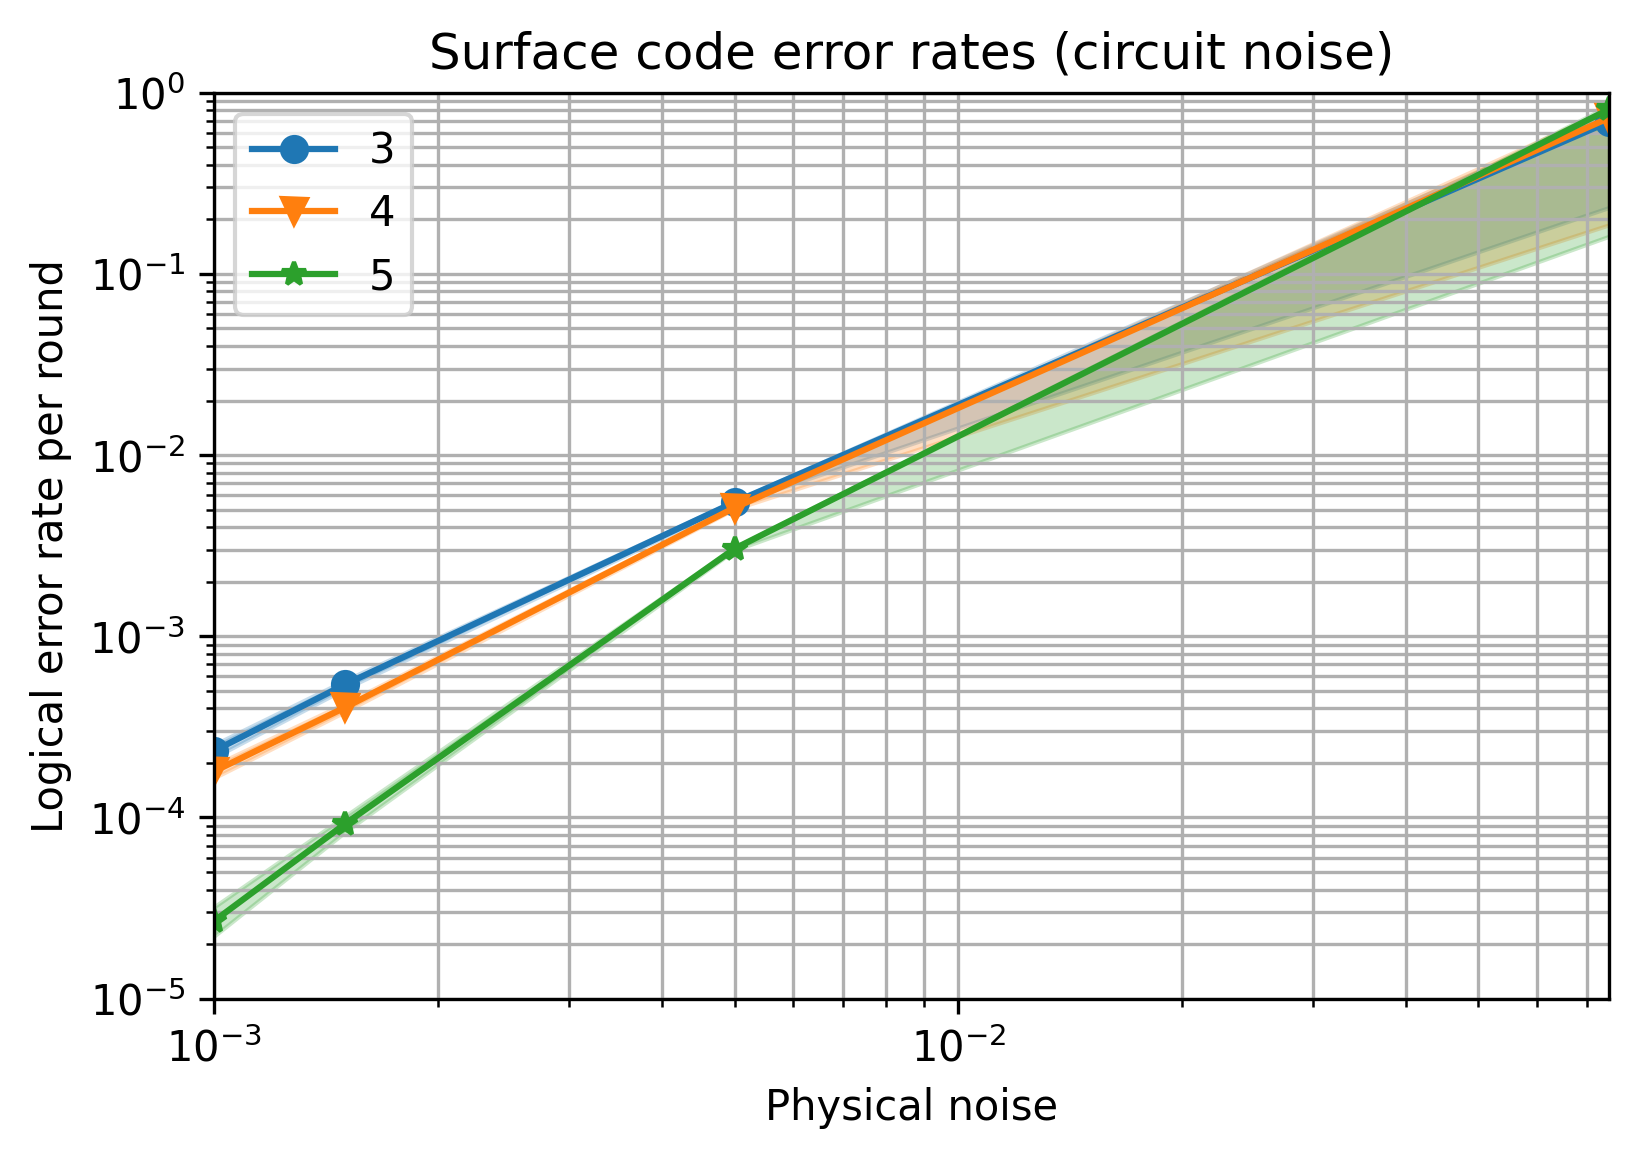

In [84]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=results,
    x_func=lambda stat: stat.json_metadata['noise'],
    group_func=lambda stat: stat.json_metadata['distance'],
    failure_units_per_shot_func=lambda stat: stat.json_metadata['rounds'],
)
ax.set_xlim(0.001, 0.075)
ax.set_ylim(1e-5, 1.)
ax.loglog()
ax.set_title("Surface code error rates (circuit noise)")
ax.set_xlabel("Physical noise")
ax.set_ylabel("Logical error rate per round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(300)

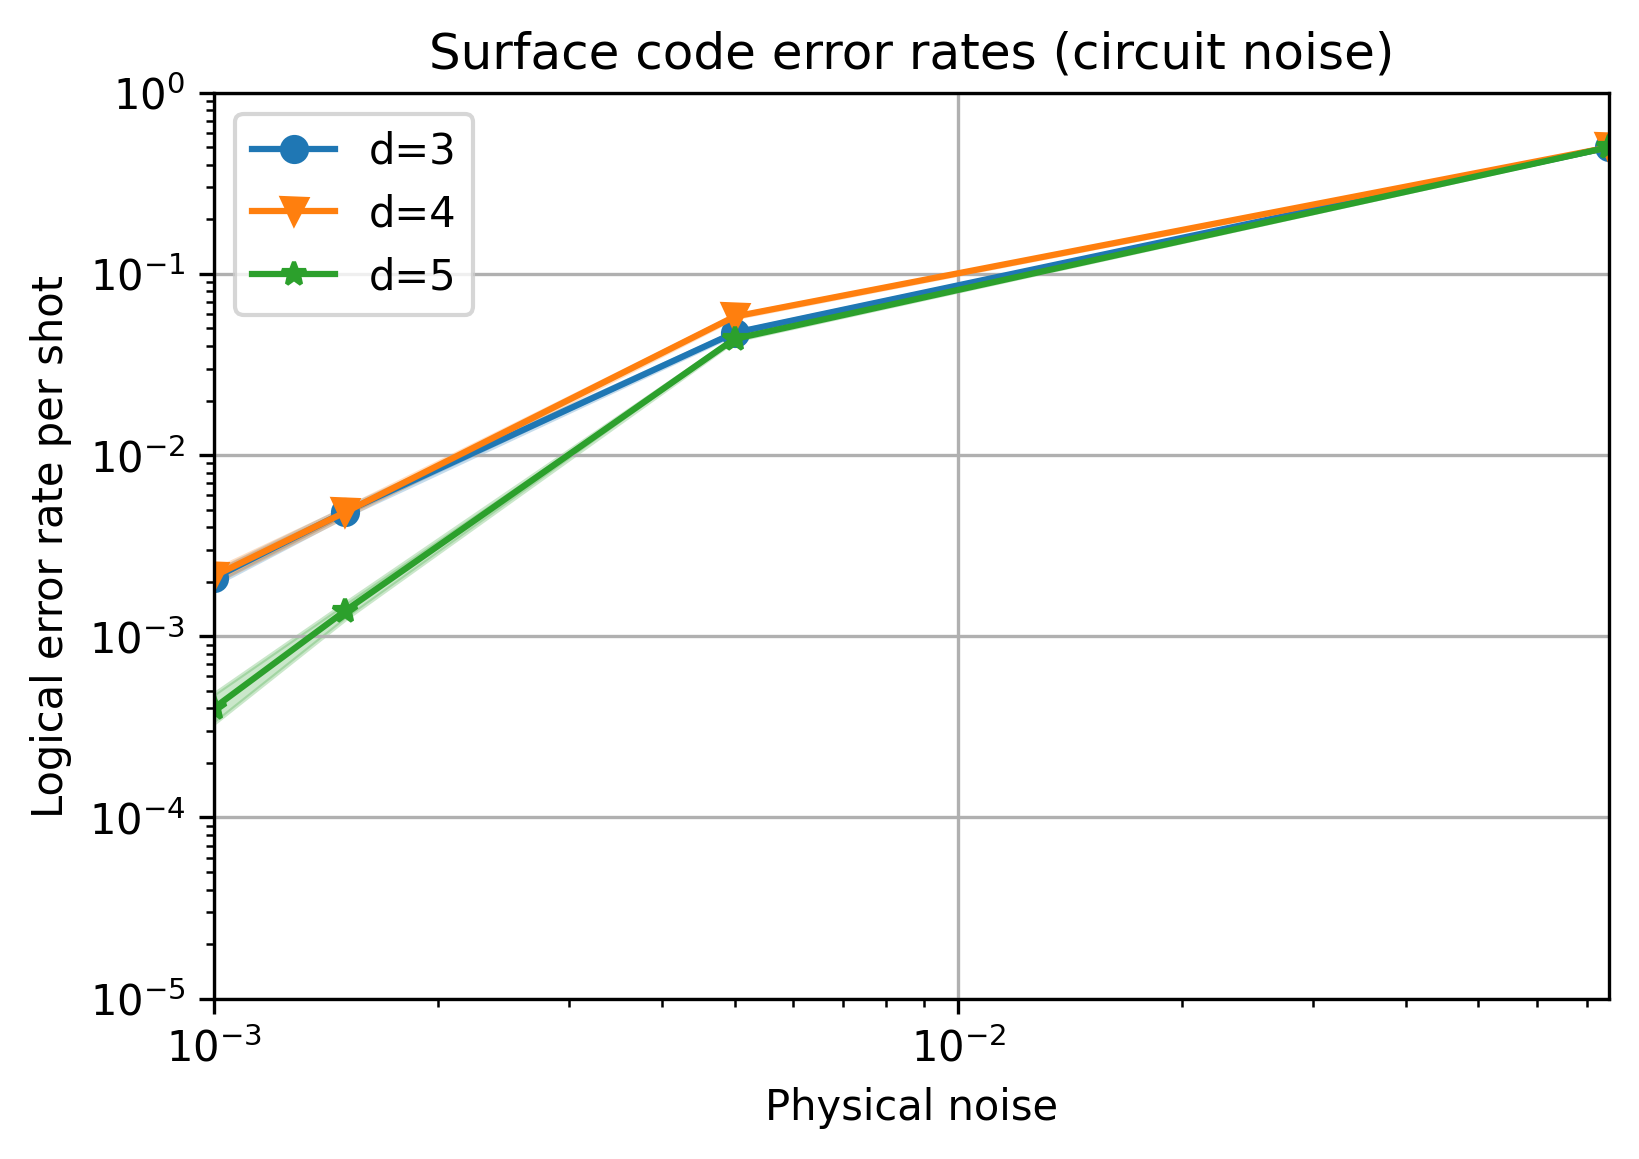

In [85]:
fig, ax = plt.subplots(1, 1)
plot_sinter_error_rate(
  ax, results, "noise", "Physical noise", "Logical error rate per shot",
  plot_label="Surface code error rates (circuit noise)",
  group_title="distance", group_labels={3: "d=3", 4: "d=4", 5: "d=5"},
  x_range=(0.001, 0.075), y_range=(1e-5, 1.)  
)
fig.set_dpi(300)